# ADS 509 Assignment 5.1: Topic Modeling

## Stephen Kuc

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [227]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load("en_core_web_sm")

In [228]:
# add any additional libaries you need here

import nltk
from nltk.tokenize import word_tokenize

In [229]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [230]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [231]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [232]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


In [233]:
df.sample(5)

,category,id,text,char_len,word_len
75,news,ca19,The Baltimore and Ohio Railroad announced yest...,12400,2260
107,romance,cp07,Spencer said nothing . `` Is there any word yo...,11943,2385
35,government,ch09,Be it enacted by the Senate and House of Repre...,13456,2451
44,government,ch18,Foreign policy in its total context With this ...,12237,2250
19,editorial,cb20,Escalation unto death The nuclear war is alrea...,12228,2299


<AxesSubplot:xlabel='category'>

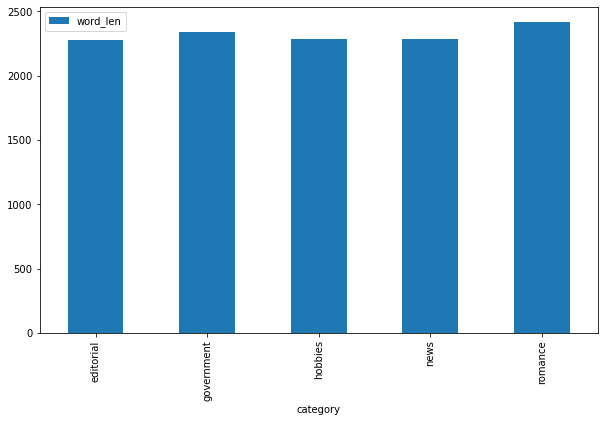

In [234]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [235]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\steph\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [236]:
count_text_vectors

<166x4941 sparse matrix of type '<class 'numpy.int64'>'
	with 72541 stored elements in Compressed Sparse Row format>

In [237]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

### Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: `count_text_vectors` holds a sparse matrix of token counts, of tokens with at least 5 occurences and no more than 70% of a document frequency, and no stopwords. 

`tfidf_text_vectors` holds a term frequency-inverse document frequency (TF-IDF) matrix. Instead of giving the raw numbers as the count_text_vectors matrix does, it finds how relevant a word is to a document. Essentially, its the product of how many times a word appears in a document and the invese document frequency of the word across a set of documents. The tokens are under the same min-max conditions as the previous matrix. 

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [238]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [239]:
W_text_matrix.shape

(166, 5)

In [240]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


In [242]:
# normalizing these topics and multiplying by 100 to see a percentage value of each topic
# IE finding how 'big' the topics are
# and how many documents can be assigned to each topic

W_text_matrix.sum(axis=0) / W_text_matrix.sum()*100

array([18.20216354, 25.88744413, 29.5696224 , 14.29955027, 12.04121966])

It appears there is a somewhat even spread among topics, however, the 5th topic is very low comparitive to the rest. When looking at the initial graph for size of each category, they seemed much more even than they are here, which may point to signs of the topics not being very accurate.

Below is the top term for each topic as well as what the topic seems to encapsulate:

mr - topic1 - politics
said - topic2 - thoughts/actions
state - topic3 - government
mrs - topic4 - people
game - topic5 - sports

Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [243]:
# adding in function to get an array of each topic

def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) 
                           for row 
                           in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) 
                               for wt, index 
                               in zip(weights,sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) 
                             for row 
                             in sorted_indices])
    
    topics = [np.vstack((terms.T, 
                     term_weights.T)).T 
              for terms, term_weights 
              in zip(sorted_terms, sorted_weights)]     
    return topics

In [245]:
feat_names = tfidf_text_vectorizer.get_feature_names_out()
weights_nmf = H_text_matrix

nmf_topics = []

topics = get_topics_terms_weights(weights_nmf, feat_names)

for row in range(len(df['text'])):
    nmf_topics.append(topics[np.argmax(W_text_matrix[row])][0][0])
    
df['nmf_topics'] = nmf_topics

In [247]:
df.head()

,category,id,text,char_len,word_len,nmf_topics
0,editorial,cb01,Assembly session brought much good The General...,12659,2200,state
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234,mr
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244,mr
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230,mr
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241,mr


In [254]:
# this doesn't quite give the topic name; but the top word per topic
# let's assign each word its correct topic

# mr - topic1 - politics
# said - topic2 - thoughts/actions
# state - topic3 - government
# mrs - topic4 - people
# game - topic5 - sports

df.loc[df['nmf_topics'] == "mr", "nmf_topics"] = "t1_politics"
df.loc[df['nmf_topics'] == "said", "nmf_topics"] = "t2_thoughts"
df.loc[df['nmf_topics'] == "state", "nmf_topics"] = "t3_govt"
df.loc[df['nmf_topics'] == "mrs", "nmf_topics"] = "t4_people"
df.loc[df['nmf_topics'] == "game", "nmf_topics"] = "t5_sports"


<AxesSubplot:xlabel='category', ylabel='nmf_topics'>

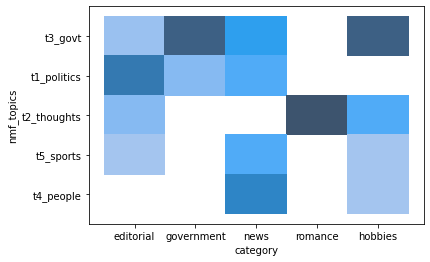

In [263]:
# viewing just nmf_topics and its corresponding topic via nmf_topics

import seaborn as sns

sns.histplot(binwidth = 1, x = "category", y = "nmf_topics", data = df, stat = "count", multiple = "dodge")

### Q: How does your five-topic NMF model compare to the original Brown categories? 

A: For most of the categories -- like editorial, news, and hobbies -- they were spread among 4 different topics. News seems to be the most spread out as they hit derived topics like 'politics', 'sports', 'people' and 'govt', which makes sense for News to be spread among those things. 

Romance seems to be firmly in the 'thoughts' topic, which seems to be interpersonal thoughts and conversations, and this makes sense. Government is, of course, split between the two government-like derived topics -- 'politics' and 'govt'. 

Overall, the five-topic NMF model doesn't do a bad job, but not very good, either. It would be nice to have the politics and gov't words be in just one topic of their own.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [307]:
svd_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_matrix = svd_model.fit_transform(tfidf_text_vectors)
H_svd_matrix = svd_model.components_

In [308]:
display_topics(svd_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


First, there is a lot of overlap between these. If we do the same method as with NMF, there will be duplicates for different topics if we go with first or second highest word; thus, we will go with the third highest. Below is that term, corresponding topic, and what the topic seems to summarize.

Topic1 - mrs - speaking/govt (this one is tought to make sense of)

Topic2 - didn - thoughts

topic3 - said - politics

topic4 - game - fun

topic5 - baseball - sports

In [ ]:
feat_names = tfidf_text_vectorizer.get_feature_names_out()
weights_nmf = H_text_matrix

nmf_topics = []

topics = get_topics_terms_weights(weights_nmf, feat_names)

for row in range(len(df['text'])):
    nmf_topics.append(topics[np.argmax(W_text_matrix[row])][0][0])
    
df['nmf_topics'] = nmf_topics

In [350]:
# comparing brown categories with SVD/LSA model
svd_topics = []

topics_svd = get_topics_terms_weights(H_svd_matrix, feat_names)

for row in range(len(df['text'])):
    svd_topics.append(topics_svd[np.argmax(W_svd_matrix[row])][2][0]) # looking at the third highest term, as 1st and 2nd will have some matches
    
df['svd_topics'] = svd_topics

In [355]:
# after some attempts, it seems there is a mis-match between what is displayed above and what is in topics_svd

topics_svd

[array([['said', '0.22397736025047624'],
        ['mr', '0.12608915527113537'],
        ['mrs', '0.11152719316106871'],
        ...,
        ['construct', '0.0015455651267919238'],
        ['eliminated', '0.0015450542316662198'],
        ['categories', '0.0013953651788832005']], dtype='<U32'),
 array([['said', '0.19024532153213256'],
        ['state', '-0.1389532649286947'],
        ['ll', '0.13349966989263473'],
        ...,
        ['adult', '-3.862763218736075e-06'],
        ['passes', '-3.3123741184474995e-07'],
        ['corners', '-2.901183585211835e-07']], dtype='<U32'),
 array([['mrs', '0.3633021429035793'],
        ['mr', '0.20013495033846815'],
        ['said', '0.12109364234218305'],
        ...,
        ['entered', '7.010368109423479e-06'],
        ['paying', '-3.3512846223654192e-06'],
        ['licensing', '-1.035915215271347e-06']], dtype='<U32'),
 array([['mrs', '0.42558447116074466'],
        ['khrushchev', '-0.1436973823432569'],
        ['berlin', '-0.113422042035982

In [351]:
# need to assign correct topic for word

# utilizing what was last printed

# Topic1 - mrs - speaking/govt (this one is tought to make sense of)
# Topic2 - ll - thoughts
# topic3 - said - politics
# topic4 - berlin - places
# topic5 - baseball - sports

df.loc[df['svd_topics'] == "mrs", "svd_topics"] = "t1_speaking"
df.loc[df['svd_topics'] == "ll", "svd_topics"] = "t2_thoughts"
df.loc[df['svd_topics'] == "said", "svd_topics"] = "t3_politics"
df.loc[df['svd_topics'] == "berlin", "svd_topics"] = "t4_places"
df.loc[df['svd_topics'] == "baseball", "svd_topics"] = "t5_sports"

<AxesSubplot:xlabel='category', ylabel='svd_topics'>

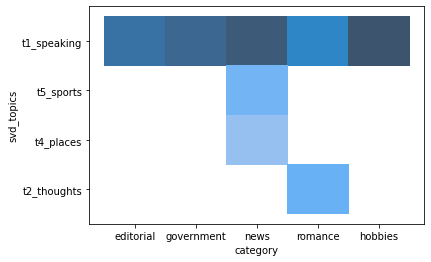

In [352]:
# viewing just nmf_topics and its corresponding topic via nmf_topics

import seaborn as sns

sns.histplot(binwidth = 1, x = "category", y = "svd_topics", data = df, stat = "count", multiple = "dodge")

### Q: How does your five-topic LSA model compare to the original Brown categories? 

A: It doesn't compare very well. While editorial, government and hobbies all were in one category, they were the same category of speaking/gov't, which, only makes sense for the government one,. News, again, was split between a few categories; and romance did not have its own category anymore. 

The 'speaking/gov't' topic seemed to still encapsulate a lot of different topics and categories. Overall, this performed worse than the NMF method.

### Q: What is your interpretation of the display topics output? 

A: For the most part, the answer was written earlier after the display topics function ran:

First, there is a lot of overlap between these. If we do the same method as with NMF, there will be duplicates for different topics if we go with first or second highest word; thus, we will go with the third highest. Below is that term, corresponding topic, and what the topic seems to summarize.

Topic1 - speaking/govt (this one is tought to make sense of)

Topic2 - thoughts

topic3 -  politics

topic4 - fun

topic5 - sports

However, when utilizing the rest of the methods to assign the topics to the existing categories, there were some issues and topic-4 seemed more so of a topic around places, thus it was changed for the final comparison.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [134]:
# fitting LDA model

lda_text_model = LatentDirichletAllocation(n_components = 5, random_state = 42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors) # fitting LDA with count_text_vectors
H_lda_text_matrix = lda_text_model.components_


In [358]:
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: These seems to have similar ways of breaking up topics as the NMF model; between topic01 and topic02, these seem to be similar to that 'government' and 'politics' with state in both, as well as president in topic 2. 

Below is how I would break them down, and how I will label these new topics when comparing to the original categories:

Topic 1 - Sports

Topic 2 - Government

Topic 3 - Politics

Topic 4 - Business

Topic 5 - Thoughts

In [359]:
# Repeating of tallying of brown categories within topics

count_feat_names = count_text_vectorizer.get_feature_names_out()
lda_topics = []

topics_lda  = get_topics_terms_weights(H_lda_text_matrix, count_feat_names)

for row in range(len(df['text'])):
    lda_topics.append(topics_lda[np.argmax(W_lda_text_matrix[row])][1][0]) # looking at the second highest term, as 1st will have some matches
    
df['lda_topics'] = lda_topics


In [361]:
# ways to assign, like with last models

# Topic 1 - Sports - right
# Topic 2 - Government - development
# Topic 3 - Politics - mr
# Topic 4 - Business - general
# Topic 5 - Thoughts - man

df.loc[df['lda_topics'] == "right", "lda_topics"] = "t1_sports"
df.loc[df['lda_topics'] == "development", "lda_topics"] = "t2_govt"
df.loc[df['lda_topics'] == "mr", "lda_topics"] = "t3_politics"
df.loc[df['lda_topics'] == "general", "lda_topics"] = "t4_business"
df.loc[df['lda_topics'] == "man", "lda_topics"] = "t5_thoughts"


<AxesSubplot:xlabel='category', ylabel='lda_topics'>

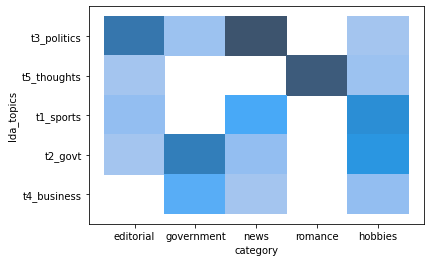

In [362]:
# viewing just nmf_topics and its corresponding topic via nmf_topics

import seaborn as sns

sns.histplot(binwidth = 1, x = "category", y = "lda_topics", data = df, stat = "count", multiple = "dodge")

### Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: This is fairly similar to what was seen with NMF, as predicted after seeing the topics it displayed. Like NMF, romance is only within one topic -- thoughts. News is spread around all topics except thoughts, which makes sense as news will cover sports, politics, government, and business. Government seems to be covering business, on top of gov't and politics, which NMF only had covered. Editorial seems to encapsulate most topics, except business; while hobbies seems to be spread among all topics, however, sports and government seem to be most common topics for hobbies.

In [136]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

C:\Users\steph\miniconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [137]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: <!-- Your answer here --> 
